In [10]:
import pandas as pd
import sklearn
from sklearn.feature_selection import VarianceThreshold

from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.metrics import RocCurveDisplay

import matplotlib.pyplot as plt



def var_thres(data, threshold=0.5):
    sel = VarianceThreshold(threshold)
    sel.fit(data)
    return data[data.columns[sel.get_support(indices=True)]]

data = pd.read_csv('cleaned_tolden_data_col_fixed.csv', index_col = 0)
label_col = 'hasAD'

y = data[label_col]
X = data.drop(label_col,axis = 1)
X = 1000000*(X.T/X.sum(axis = 1)).T

X_train,X_test,y_train,y_test = sklearn.model_selection.train_test_split(X,y,test_size=0.2, random_state=666)

#filter out low-variance genes
high_var_X_train = var_thres(X_train, 0.8)
high_var_X_test = X_test[high_var_X_train.columns]

#renormalize
high_var_X_train = 1000000*(high_var_X_train.T/high_var_X_train.sum(axis = 1)).T
high_var_X_test = 1000000*(high_var_X_test.T/high_var_X_test.sum(axis = 1)).T

#add rank information
high_var_X_train = high_var_X_train.join(high_var_X_train.rank(axis=1),rsuffix='_RANK')
high_var_X_test = high_var_X_test.join(high_var_X_test.rank(axis=1),rsuffix='_RANK')

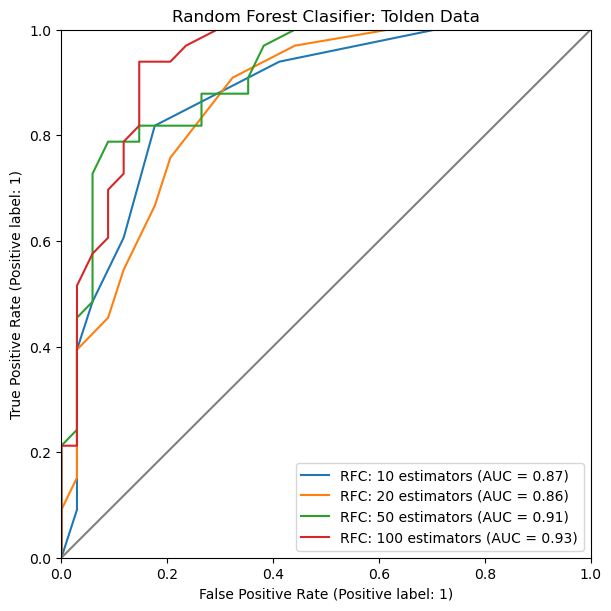

In [11]:
fig,ax = plt.subplots(1,1,constrained_layout = True)
fig.set_size_inches((6,6))

classifiers = {}

for n in [10,20,50,100]:

    rfc = RF(n_estimators=n, random_state=666)
    rfc.fit(high_var_X_train, y_train)

    y_pred = [x[1] for x in rfc.predict_proba((high_var_X_test))]

    display = RocCurveDisplay.from_predictions(
        y_test,
        y_pred,
        name='RFC: {n} estimators'.format(n=n),
        ax=ax
    )
    
    classifiers[n] = rfc

ax.set_xlim((0,1))
ax.set_ylim((0,1))

ax.plot([0,1],[0,1], color = 'grey')

ax.set_title('Random Forest Clasifier: Tolden Data')

plt.show()

In [13]:
silver_data = pd.read_csv('cleaned_silver_data_cpm_times10000.csv', index_col = 0)

#convert to cpm and restrict to chosen genes from previous dataset
silver_X = silver_data[[x for x in high_var_X_train.columns if '_RANK' not in x]]/10000
silver_y = silver_data[label_col]

#renormalize
silver_X = 1000000*(silver_X.T/silver_X.sum(axis = 1)).T

#add rank information
silver_X = silver_X.join(silver_X.rank(axis=1),rsuffix='_RANK')

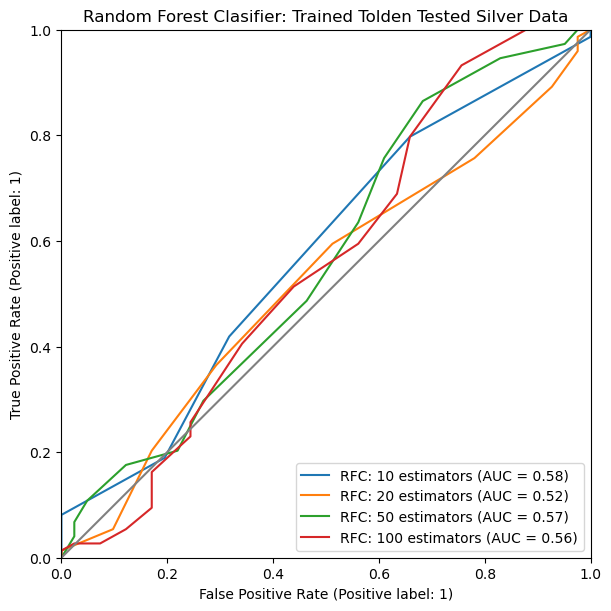

In [14]:
fig,ax = plt.subplots(1,1,constrained_layout = True)
fig.set_size_inches((6,6))

for n in [10,20,50,100]:

    rfc = classifiers[n]

    y_pred = [x[1] for x in rfc.predict_proba((silver_X))]

    display = RocCurveDisplay.from_predictions(
        silver_y,
        y_pred,
        name='RFC: {n} estimators'.format(n=n),
        ax=ax
    )
    
    classifiers[n] = rfc

ax.set_xlim((0,1))
ax.set_ylim((0,1))

ax.plot([0,1],[0,1], color = 'grey')

ax.set_title('Random Forest Clasifier: Trained Tolden Tested Silver Data')

plt.show()